# Bagging & Boosting

In [ ]:
#@title Import libraries {display-mode: "form"}

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#@title Helper functions {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

# Helper functions
def draw_grid(x_lim=np.array([-4, 4]), y_lim=np.array([-4, 4]), ax=None):
    """Draw an empty grid"""
    ax = ax or plt.gca()
    # Draw ticks and grid
    for i in range(int(x_lim.min()), int(x_lim.max())):
        ax.axvline(i, linestyle='--', color='#ecf0f1', zorder=0)
        ax.plot([i, i], [0.05, -0.05], color='#2c3e50')
    for i in range(int(y_lim.min()), int(y_lim.max())):
        ax.axhline(i, linestyle='--', color='#ecf0f1', zorder=0)
        ax.plot([0.05, -0.05], [i, i], color='#2c3e50')
    # x and y axis
    ax.axhline(0, color='#2c3e50', zorder=0)
    ax.axvline(0, color='#2c3e50', zorder=0)
    ax.scatter([0], [0], color='#c0392b', zorder=0)

    ax.grid(False)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)

def draw_vectors(vectors, origin='origin', cmap=None, labels=None):
    if cmap:
        colors = cmap
    else:
        colors = ['#3498db', '#e67e22', '#f1c40f', '#2ecc71', '#1abc9c']

    if origin == 'origin':
        x_0 = np.zeros(len(vectors))
        y_0 = np.zeros(len(vectors))
    else:
        x_0, y_0 = origin[:, 0], origin[:, 1]
    ax = plt.gca()
    if labels:
        for i in range(len(vectors)):
            ax.text(vectors[i][0]+0.1, vectors[i][1]+0.2, labels[i],
                    {'color': 'black', 'fontsize': 14, 'ha': 'center', 'va': 'center',
                    'bbox': dict(boxstyle="round", fc="white", alpha=0)})
    ax.quiver(x_0, y_0, vectors[:, 0], vectors[:, 1],
              angles='xy', scale_units='xy', scale=1, color=colors)

def projection(x, y, draw_vector=True):
    color = '#95a5a6'
    ax = plt.gca()
    dot_product = np.dot(x, y)
    y_norm = y / np.dot(y, y)
    x_projection = y_norm * dot_product
    ax.plot((x[0], x_projection[0]), (x[1], x_projection[1]), linestyle='--', linewidth=3, c=color)
    if draw_vector:
        draw_vectors(np.array([x_projection]), cmap=['#bdc3c7'])

def determinant_area(i_hat, j_hat):
    ax = plt.gca()
    sum_vector = i_hat + j_hat
    polygon = plt.Polygon([(0, 0), i_hat, sum_vector, j_hat], fill=True, color='#f39c12', alpha=0.3)
    print('Determinant Area:', np.abs(i_hat[0]*j_hat[1] - i_hat[1]*j_hat[0]))
    ax.add_line(polygon)
    
def projection_onto_H(x, w, b):
    ax = plt.gca()
    alpha = (np.dot(x, w) + b) / np.dot(w, w)
    d = alpha * w
    x_projection = x - d
    ax.plot((x[0], x_projection[0]), (x[1], x_projection[1]), linestyle='--', linewidth=3, c='#95a5a6')
    
def plot_margins(X, y, w, b):
    ax = plt.gca()
    gamma = np.abs(np.dot(X, w) + b) / np.sqrt(np.dot(w, w))
    x_pos = X[y==1][np.argmin(gamma[y == 1])]
    x_neg = X[y==0][np.argmin(gamma[y == 0])]
    d_pos = gamma[y==1][np.argmin(gamma[y == 1])]
    d_neg = gamma[y==0][np.argmin(gamma[y == 0])]
    
    ax.scatter([x_pos[0], x_neg[0]],[x_pos[1], x_neg[1]], s=150, linewidth=2, facecolor='none', edgecolors='#2c3e50')
    projection_onto_H(x_pos, w, b)
    projection_onto_H(x_neg, w, b)
    ax.set_title(f'Margin Class +1: {d_pos:.3f}, Class -1: {d_neg:.3f}', fontsize=24)
    
def plot_svc(model, plot_support=True):
    ax = plt.gca()
    xlim = ax.get_xlim() 
    ylim = ax.get_ylim() 
    
    # create grid (coordinate system - x and y) to evaluate model
    x = np.linspace(xlim[0], xlim[1], 40)
    y = np.linspace(ylim[0], ylim[1], 40) 
    X, Y = np.meshgrid(x, y)
    flatten_X = X.ravel() 
    flatten_Y = Y.ravel()
    xy = np.vstack([flatten_X, flatten_Y]).T 
    Z = model.decision_function(xy).reshape(X.shape)

    # Plot decision boundary and margins.
    ax.contour(X, Y, Z, colors='k', # draw filled contours
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    
    # plot circle around the support vectors returned by fitted SVC model
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0], 
                   model.support_vectors_[:, 1],
                   s=150, linewidth=2, facecolors='none', edgecolors='k')
        
def plot_hyperplane(w, b):
    ax = plt.gca()
    draw_vectors(np.array([w]), origin=np.array([[(-b/w[0]), 0]]))
    x_1 = np.linspace(-8, 8, 100)
    ax.plot(x_1, (-w[0]/w[1])*x_1 + (-b/w[1]))

def visualize_classifier(model, X, y, ax=None, cmap='viridis'):
    ax = ax or plt.gca()
    
    # Plot the training points
    # ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
    #            clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=500),
                         np.linspace(*ylim, num=500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

def plot_classifier_with_2d_data(clf, X, y, ax=None, title='', cmap='viridis'):
    ax = ax or plt.gca()

    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)

    visualize_classifier(clf, X, y, ax=ax)

    ax.set_title(title)
    ax.set_xlabel(r'$x_1$', fontsize=20)
    ax.set_ylabel(r'$x_2$', fontsize=20)

def split_data(data):
    
    X = data.drop('Class', axis=1)
    y = data['Class']

    # Train-Test slpit of 70%-30%
    X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, stratify=y, random_state=102)

    return (X_train, X_test, y_train, y_test)

def base_learners_evaluations(data):
    X_train, X_test, y_train, y_test = split_data(data)
    
    idx = []
    scores = {'F1 score': [], 'Recall':[]}
    for bc in base_classifiers:
        lr = bc[1]
        lr.fit(X_train, y_train)

        predictions = lr.predict(X_test)

        idx.append(bc[0])
        scores['F1 score'].append(metrics.f1_score(y_test, predictions))
        scores['Recall'].append(metrics.recall_score(y_test, predictions))

    return pd.DataFrame(data=scores, index=idx)

def ensemble_evaluation(data, model, label='Original'):
    X_train, X_test, y_train, y_test = split_data(data)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)       
    return pd.DataFrame({'F1 Score': [metrics.f1_score(y_test, predictions)],
                         'Recall': [metrics.recall_score(y_test, predictions)]}, index=[label])
    
def plot_models_comparison(title='F1 Score'):
    labels = models_comparison.keys()
    original_data = [models_comparison[model][title]['Original'] for model in labels]
    filtered_data = [models_comparison[model][title]['Filtered'] for model in labels]

    best_score_each_model = [max(original_data[i], filtered_data[i]) for i in range(len(original_data))]
    labels = [x for _, x in sorted(zip(best_score_each_model, labels), key=lambda pair: pair[0])]
    original_data = [x for _, x in sorted(zip(best_score_each_model, original_data), key=lambda pair: pair[0])]
    filtered_data = [x for _, x in sorted(zip(best_score_each_model, filtered_data), key=lambda pair: pair[0])]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(8,8))
    rects1 = ax.bar(x - width/2, original_data, width, label='Original Data')
    rects2 = ax.bar(x + width/2, filtered_data, width, label='Filtered Data')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.3f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

In [ ]:
a = [1, 2, 3, 4, 5]
# [1, 1, 2];  [2, 4, 5]; [5, 5, 5]

## Bagging or Bootstrap Aggregating

Bagging is an **ensemble learning** technique. The idea is training individual classifiers with **bootstrap** samples (uniformly randomly sample with replacement) and then make predictions based on majority voting. More formally:

* Sample the $k$ datasets $D_1,\dots,D_k$, and $D_i$ is picked uniformly at random with replacement from $D$.
* For each $D_i$ train a classifier $h_i()$.
* The final classifier is $h(\mathbf{x})=\frac{1}{k}\sum_{j=1}^k h_j(\mathbf{x})$ 







**The law of large numbers**: For i.i.d random variables $x_i$ with mean $\bar{x}$:

$$
\frac{1}{k}\sum_{i = 1}^{k}x_i \rightarrow \bar{x} \textrm{ as }  k\rightarrow \infty
$$

Then we have:

$$
h(\mathbf{x})=\frac{1}{k}\sum_{j=1}^k h_j(\mathbf{x}) \rightarrow \bar{h}
$$

If $h \rightarrow \bar{h}$, then the variance error will vanish

$$
E\left[\left(h_{D}(\mathbf{x}) - \bar{h}(\mathbf{x})\right)^{2}\right] \rightarrow 0
$$

**Quiz:** What kind of problems we still have?

### Random Forest

One of the most famous and useful bagged algorithms is the **Random Forest**. A Random Forest is essentially nothing else but bagged Decision Trees.

The algorithms works as follow:

* Sample the $k$ datasets $D_1,\dots,D_k$, and $D_i$ with replacement from $D$
* For each $D_i$ train a Decision Tree with **subsample features without replacement** (this increases the variance of the trees)
* The final classifier is $h(\mathbf{x})=\frac{1}{k}\sum_{j=1}^k h_j(\mathbf{x})$ 

**Demo**

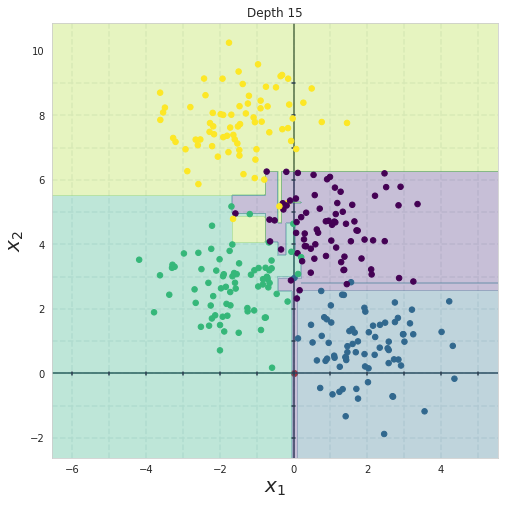

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs, make_moons

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
depth = 15
clf = DecisionTreeClassifier(max_depth=depth)

# Plotting
plt.figure(figsize=(8, 8))
draw_grid(x_lim=np.array([-6, 6]), y_lim=np.array([-2, 10]))

plot_classifier_with_2d_data(clf, X, y, title=f'Depth {depth}')

plt.show()

Different training data $\rightarrow$ different $h(x)$ $\rightarrow$ Decision Tree classifier has high variance error.

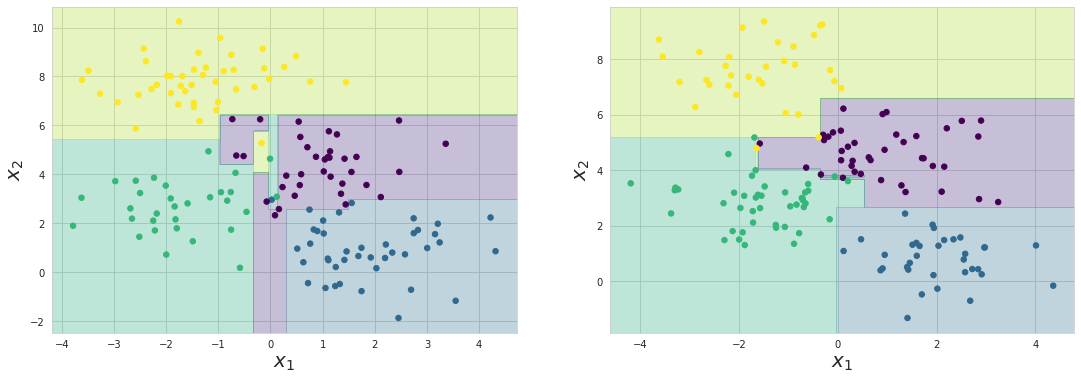

In [ ]:
clf = DecisionTreeClassifier(max_depth=depth)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.2)
plot_classifier_with_2d_data(clf, X[::2], y[::2], ax=ax[0])
plot_classifier_with_2d_data(clf, X[1::2], y[1::2], ax=ax[1])
plt.show()

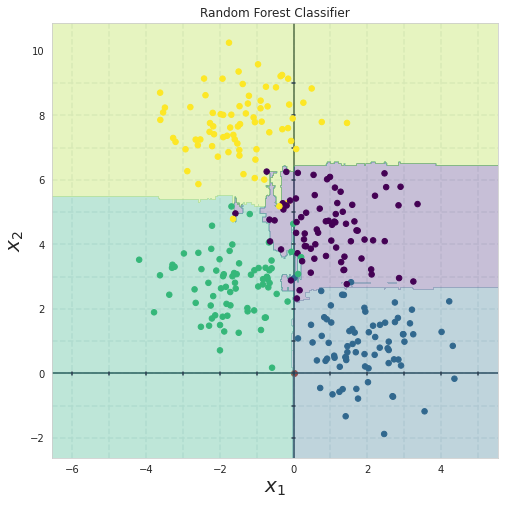

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, max_depth=100)

plt.figure(figsize=(8,8))
draw_grid(x_lim=np.array([-6, 6]), y_lim=np.array([-2, 10]))

plot_classifier_with_2d_data(rf_clf, X, y, 
                             title=f'Random Forest Classifier')

plt.show()

## Boosting

In boosting, the ensemble also consists of weak learners (e.g. Decision Tree). The key concept behind boosting is to focus on training samples that are hard to classify. In other words, **let the weak learners subsequently learn from misclassified training samples** to improve the performance of the ensemble.

### AdaBoost

The algorithm assigns weights to all data points, samples the next training set based on the weights of the data points:

1. Initialize all of the train set instance's weights equally, so their sum equals 1.
2. Generate a new set by sampling with replacement, according to the weights.
3. Train a weak learner on the sampled set.
4. Calculate its error on the original train set.
5. Add the weak learner to the ensemble and save its error rate.
6. Adjust the weights, increasing the weights of misclassified instances and decreasing the weights of correctly classified instances.
7. Repeat from Step 2.
8. The weak learners are combined by voting. Each learner's vote is weighted, according to its error rate.

<div align='center'>
    <img src="https://i.imgur.com/rWJy2jK.png" width="50%" />
</div>


### Other popular boosting algorithms

Boosting is a great way to turn week classifiers into a strong classifier. It defines a whole family of algorithms:

**Gradient boosting** is a more generalized boosting framework compared to AdaBoost, which also makes it more complicated and math-intensive. Instead of trying to emphasize problematic instances by assigning weights and resampling the dataset, gradient boosting builds each base learner on the previous learner's errors.

**XGBoost** is a boosting library with parallel, GPU, and distributed execution support. It has helped many machine learning engineers and data scientists to win Kaggle.com competitions. 

Two other boosting libraries that are gaining popularity are Microsoft's **LightGBM** and Yandex' **CatBoost**. Both of these libraries can match (and even outperform) XGBoost, under certain circumstances. Nonetheless, XGBoost is the best of all three out of the box, without the need of fine-tuning and special data treatment.



### Benchmarking

In [ ]:
data = pd.read_csv('https://intro-to-ml-minhdh.s3-ap-southeast-1.amazonaws.com/FTMLE/creditcard.csv')

In [ ]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [ ]:
492/len(data)

0.001727485630620034

In [ ]:
# Standardize data
data['Time'] = (data['Time'] - data['Time'].mean()) / data['Time'].std()
data['Amount'] = (data['Amount'] - data['Amount'].mean()) / data['Amount'].std()

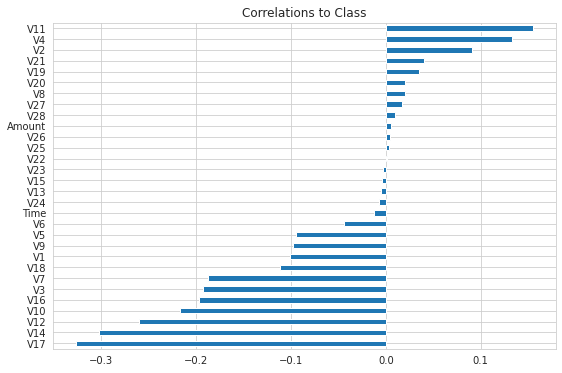

In [ ]:
# Analyze correlation
plt.figure(figsize=(9,6))

correlations = data.corr()['Class'].drop('Class')
correlations.sort_values().plot(kind='barh')

plt.title('Correlations to Class')
plt.show()

In [ ]:
# Filtering features with lower absolute value than a threshold
threshold = 0.1

features = list(correlations[(abs(correlations)>threshold)].index.values)
features.append('Class')

data_fs = data[features]

In [ ]:
data_fs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 12 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V3      284807 non-null  float64
 2   V4      284807 non-null  float64
 3   V7      284807 non-null  float64
 4   V10     284807 non-null  float64
 5   V11     284807 non-null  float64
 6   V12     284807 non-null  float64
 7   V14     284807 non-null  float64
 8   V16     284807 non-null  float64
 9   V17     284807 non-null  float64
 10  V18     284807 non-null  float64
 11  Class   284807 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 26.1 MB


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Base learners
base_classifiers = [('Decision Tree 3', DecisionTreeClassifier(max_depth=3)),
                    ('Decision Tree 5', DecisionTreeClassifier(max_depth=5)),
                    ('Decision Tree 8', DecisionTreeClassifier(max_depth=8)),
                    ('Naive Bayes', GaussianNB()),
                    ('Logistic Regression', LogisticRegression())]

base_learners_evaluations(data)

,F1 score,Recall
Decision Tree 3,0.764286,0.722973
Decision Tree 5,0.813688,0.722973
Decision Tree 8,0.765152,0.682432
Naive Bayes,0.114921,0.837838
Logistic Regression,0.682540,0.581081


In [ ]:
# Evaluate after feature selection
base_learners_evaluations(data_fs)

,F1 score,Recall
Decision Tree 3,0.767528,0.702703
Decision Tree 5,0.826568,0.756757
Decision Tree 8,0.817518,0.756757
Naive Bayes,0.209917,0.858108
Logistic Regression,0.688259,0.574324


**Voting Classifier**

In [ ]:
%%time
from sklearn.ensemble import VotingClassifier

models_comparison = {}

base_classifiers = [('Decision Tree 3', DecisionTreeClassifier(max_depth=3)),
                    ('Decision Tree 5', DecisionTreeClassifier(max_depth=5)),
                    ('Decision Tree 8', DecisionTreeClassifier(max_depth=8)),
                    ('Naive Bayes', GaussianNB()),
                    ('Logistic Regression', LogisticRegression())]

ensemble = VotingClassifier(base_classifiers)     

ensemble_data_origin = ensemble_evaluation(data, ensemble, label='Original')
ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble, label='Filtered')

models_comparison['Voting'] = pd.concat([ensemble_data_origin, ensemble_data_filtered], axis=0)

CPU times: user 27.2 s, sys: 1.96 s, total: 29.2 s
Wall time: 26 s


In [ ]:
models_comparison['Voting']

,F1 Score,Recall
Original,0.791367,0.743243
Filtered,0.810036,0.763514


**Bagging**

In [ ]:
%%time
from sklearn.ensemble import BaggingClassifier

ensemble = BaggingClassifier(n_estimators=10,
                             base_estimator=DecisionTreeClassifier(max_depth=5))

ensemble_data_origin = ensemble_evaluation(data, ensemble, label='Original')
ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble, label='Filtered')
models_comparison['Bagging'] = pd.concat([ensemble_data_origin, ensemble_data_filtered], axis=0)

CPU times: user 41.4 s, sys: 29.5 ms, total: 41.4 s
Wall time: 41.5 s


In [ ]:
models_comparison['Bagging']

,F1 Score,Recall
Original,0.820896,0.743243
Filtered,0.784906,0.702703


**AdaBoost**

In [ ]:
%%time
from sklearn.ensemble import AdaBoostClassifier

ensemble = AdaBoostClassifier(n_estimators=80)

ensemble_data_origin = ensemble_evaluation(data, ensemble, label='Original')
ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble, label='Filtered')
models_comparison['AdaBoost'] = pd.concat([ensemble_data_origin, ensemble_data_filtered], axis=0)

CPU times: user 1min 58s, sys: 122 ms, total: 1min 58s
Wall time: 1min 58s


In [ ]:
models_comparison['AdaBoost']

,F1 Score,Recall
Original,0.781022,0.722973
Filtered,0.794118,0.729730


**Random Forest**

In [ ]:
%%time
from sklearn.ensemble import RandomForestClassifier

ensemble = RandomForestClassifier(n_estimators=50, criterion="entropy", n_jobs=-1)

ensemble_data_origin = ensemble_evaluation(data, ensemble, label='Original')
ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble, label='Filtered')
models_comparison['RandomForest'] = pd.concat([ensemble_data_origin, ensemble_data_filtered], axis=0)

CPU times: user 2min 25s, sys: 118 ms, total: 2min 25s
Wall time: 1min 14s


In [ ]:
models_comparison['RandomForest']

,F1 Score,Recall
Original,0.844106,0.750000
Filtered,0.836502,0.743243


**XGBoost**

In [ ]:
%%time
from xgboost import XGBClassifier

ensemble = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')

ensemble_data_origin = ensemble_evaluation(data, ensemble, label='Original')
ensemble_data_filtered = ensemble_evaluation(data_fs, ensemble, label='Filtered')
models_comparison['XGBoost'] = pd.concat([ensemble_data_origin, ensemble_data_filtered], axis=0)

CPU times: user 1.12 s, sys: 360 ms, total: 1.48 s
Wall time: 2.2 s


In [ ]:
models_comparison['XGBoost']

,F1 Score,Recall
Original,0.840149,0.763514
Filtered,0.817204,0.770270


**Model Comparison**

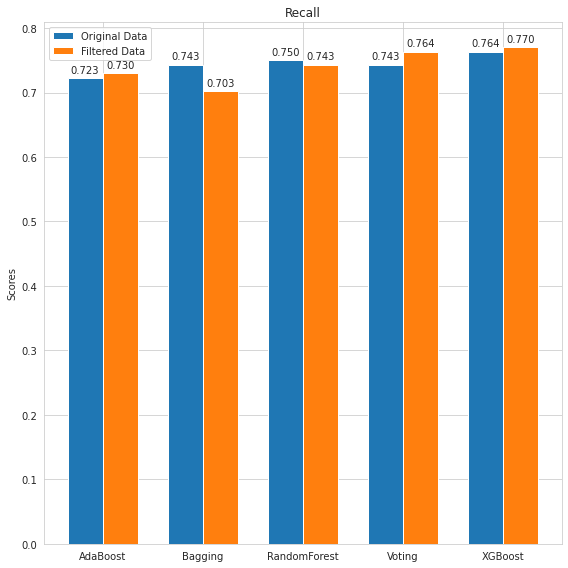

In [ ]:
plot_models_comparison('Recall')

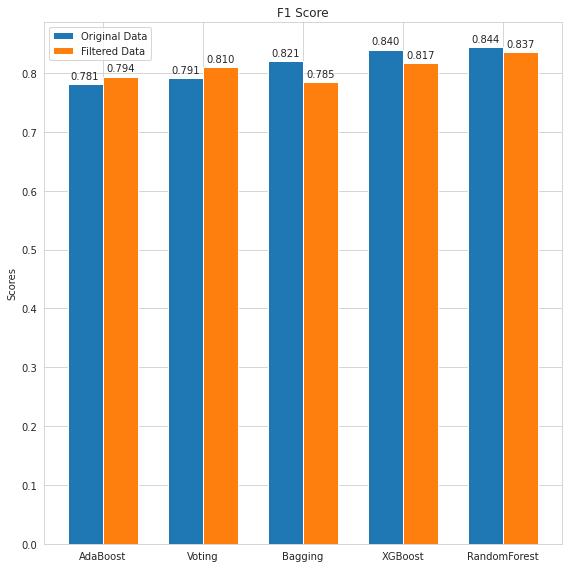

In [ ]:
plot_models_comparison('F1 Score')